#### Setup GEE packages

In [2]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='kazi34')

In [3]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import rasterio
from pathlib import Path
import pandas as pd

#### Load the AOI shape file and extract the bounding box

In [5]:
shape_path = Path (r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month2_remotesensing_ndvi_timeseries\vectors")

The bounding box of Esslingen: [ 9.08 48.51  9.6  48.79]


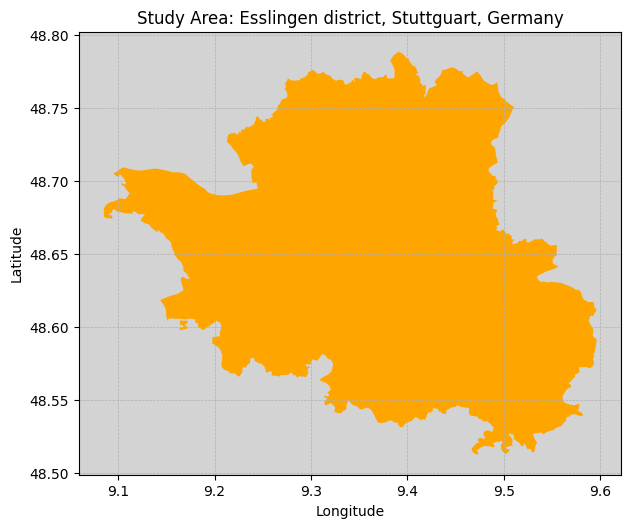

In [131]:
#loading area shape file, preparing the bounding box

districts_gdf = gpd.read_file(shape_path/'germany_Districts_level_3.shp')
esslingen_gdf = districts_gdf[districts_gdf['shape3'] == 'Esslingen']
bbox = np.round(esslingen_gdf.total_bounds, 2)

print(f"The bounding box of Esslingen: {bbox}") 

fig, ax = plt.subplots(figsize=(7, 10))
esslingen_gdf.plot(ax=ax, color='orange')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Study Area: Esslingen district, Stuttguart, Germany')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.set_facecolor('lightgrey')
fig.savefig(result_path/'aoi.jpg', dpi=300)

#### Accessing the Landsat data

In [10]:
#create the bounding box geometry
aoi = ee.Geometry.BBox(*bbox) #unpacking the bbox list into arguments

#load image collection and filter it
data_collection = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(aoi)
    .filterDate('2018-01-01', '2021-12-31')
)

data_collection = data_collection.select(['SR_B4', 'SR_B5', 'QA_PIXEL'], ['red', 'nir', 'QA_PIXEL'])
print(f"Total {data_collection.size().getInfo()} images are selected")


Total 133 images are selected


#### Pre-processing: clipping to watershed

In [11]:
import json

In [12]:
#converting geopandas geometry to GeoJSON geometry
esslingen_json = json.loads(esslingen_gdf.to_json())['features'][0]['geometry']

#create ee Geometry
esslingen_geom = ee.Geometry(esslingen_json)


#clipping
clipped_collection = data_collection.map(lambda img: img.clip(esslingen_geom))

#### Preprocessing: Cloud Masking

In [13]:
#defining a cloud masking function
def landsat_mask_cloud(image):
    qa = image.select('QA_PIXEL') #select the QA band

    #prepare mask
    cloud_mask = 1 << 3 #bit 3 = cloud
    cloud_shadow_mask = 1 << 4 #bit 4 = cloud_shadow
    snow_mask = 1 << 5 #bit 5 = snow 

    mask = qa.bitwiseAnd(cloud_mask).eq(0)\
    .And(qa.bitwiseAnd(cloud_shadow_mask).eq(0)) \
    .And(qa.bitwiseAnd(snow_mask).eq(0))

    return image.updateMask(mask)

In [14]:
#applying the cloud masking function to the clipped images
cloudfree_collection = clipped_collection.map(landsat_mask_cloud)

#### Calculating NDVI

In [15]:
#defining a
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['nir', 'red']).rename('ndvi')
    return image.addBands(ndvi) 

#### Visualizing NDVI map

In [16]:
ndvi_collection = cloudfree_collection.map(calculate_ndvi)

In [146]:
first_image = ndvi_collection.first().select('ndvi')
composite_image = ndvi_collection.mean().select('ndvi')

vis_params = {
    'min': 0.0,
    'max': 0.55,
    'palette': ['white', 'grey', 'yellow', 'green', 'darkgreen']
}

maap = geemap.Map()

maap.add_basemap('HYBRID')

maap.centerObject(esslingen_geom, zoom=10)

maap.addLayer(esslingen_geom, {}, 'Boundary', False)

maap.addLayer(composite_image, vis_params, 'NDVI', opacity=0.9)

maap.add_legend(
    title="Mean NDVI Esslingen: Year 2020-2021",
    colors=['#ffffff', '#808080', '#ffff00', '#008000', '#006400'],
    labels=['NDVI = (0-0.11)', 'NDVI = (0.11-0.22)', 'NDVI = (0.22-0.33)', 'NDVI = (0.33-0.44)', 'NDVI = (0.44-0.55)']
)
maap

Map(center=[48.64800124478012, 9.369141598492781], controls=(WidgetControl(options=['position', 'transparent_b…

#### Investigating NDVI raster value: print value range

In [22]:
#lets check the stats for NDVI
stats = first_image.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), '', True),
    geometry=esslingen_geom,
    scale=30,
    maxPixels=1e9
)

print(stats.getInfo())

{'ndvi_max': 0.933216462142082, 'ndvi_mean': 0.20468820749059508, 'ndvi_min': -0.006099748833871547}


Seems like we have no pixel value in the first_image. One probable reason is, all the pixels were masked during cloud masking. To confirm, lets count the non masked pixels.

In [23]:
pixel_count = first_image.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=esslingen_geom,
    scale=30,
    maxPixels=1e9
)

print(pixel_count.getInfo())

{'ndvi': 17977}


Here it confirms that int he first_image there is no non-masked pixels. That is why it was blank while visualizing.
In such cases we go for composite images. Let's check the stats of the mean-composite:

In [24]:
stats = composite_image.reduceRegion(
    reducer=ee.Reducer.minMax().combine(ee.Reducer.mean(), '', True),
    geometry=esslingen_geom,
    scale=30,
    maxPixels=1e9
)
print(stats.getInfo())

{'ndvi_max': 0.5004621148109436, 'ndvi_mean': 0.2947656734902895, 'ndvi_min': -0.02980920672416687}


In [25]:
pixel_count = composite_image.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=esslingen_geom,
    scale=30,
    maxPixels=1e9
)

print(pixel_count.getInfo())

{'ndvi': 1075107}


#### Extracting NDVI time series using zonal statistics

In [26]:
#defining a function to calculate the mean NDVI
def calculate_zonal_mean(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=esslingen_geom,
        scale=30,
        maxPixels=1e9
    )

    return ee.Feature(None, {
        'date': image.date().format('YYYY-MM-dd'),
        'NDVI': mean.get('ndvi')
    })

In [27]:
#extract the mean using the function
mean_ndvi_series = ee.FeatureCollection(ndvi_collection.map(calculate_zonal_mean))

In [28]:
result_path = Path(r"C:\Users\kazii\OneDrive - TUM\Desktop\USGS_PyforHyd\project_1\month2_remotesensing_ndvi_timeseries\results")

,NDVI
date,
2018-01-10,0.164864
2018-01-19,0.204688
2018-01-26,NaN
2018-02-04,NaN
2018-02-27,NaN
...,...
2021-11-11,0.226829
2021-11-18,NaN
2021-11-27,0.214719


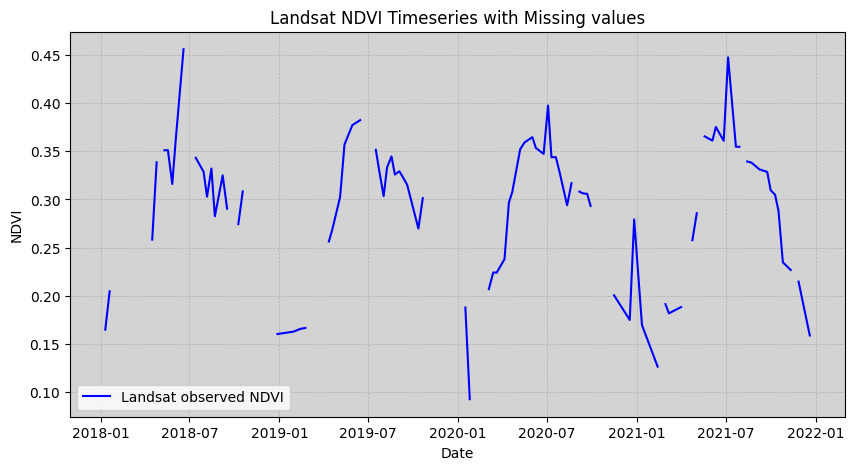

In [130]:
#converting into a dataframe
out_csv = result_path/'mean_ndvi_series.csv'
geemap.ee_to_csv(mean_ndvi_series, filename=str(out_csv))
df = pd.read_csv(result_path/'mean_ndvi_series.csv')
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d', errors='coerce')
df.set_index('date', inplace=True)
df.sort_index(inplace=True)
display(df)

#plotting
fig, ax = plt.subplots(figsize=(10, 5))
display(ax.plot(df.NDVI, color='blue', label='Landsat observed NDVI'))
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')
ax.set_title('Landsat NDVI Timeseries with Missing values')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend()
ax.set_facecolor('lightgrey')
fig.savefig(result_path/'NDVI_w_missing.jpg', dpi=300)

#### Handling missing data

In [134]:
#How many missing data?
df['NDVI'].isna().sum()

np.int64(35)

In [135]:
#make a df with missing data and check details
nandf = df[df['NDVI'].isna()]
nandf

,NDVI
date,
2018-01-26,NaN
2018-02-04,NaN
2018-02-27,NaN
2018-03-15,NaN
2018-03-31,NaN
2018-04-09,NaN
2018-05-02,NaN
2018-06-28,NaN
2018-07-05,NaN


Here, most of the missing values are not close and there is not any big gaps. Thus we can use easy linear interpolation. But linear interpolation will ignore seasonal variation. As we want to see to seasonally vegetation changes, we don't want that. Thus we will use Spline interpolation that take seasonality into account.

In [136]:
#interpolate with spline method and make a new column 
df['NDVI_interp'] = df['NDVI'].interpolate(method='spline', order=3)

In [137]:
df

,NDVI,NDVI_interp
date,,
2018-01-10,0.164864,0.164864
2018-01-19,0.204688,0.204688
2018-01-26,NaN,0.271115
2018-02-04,NaN,0.271954
2018-02-27,NaN,0.273988
...,...,...
2021-11-11,0.226829,0.226829
2021-11-18,NaN,0.292861
2021-11-27,0.214719,0.214719


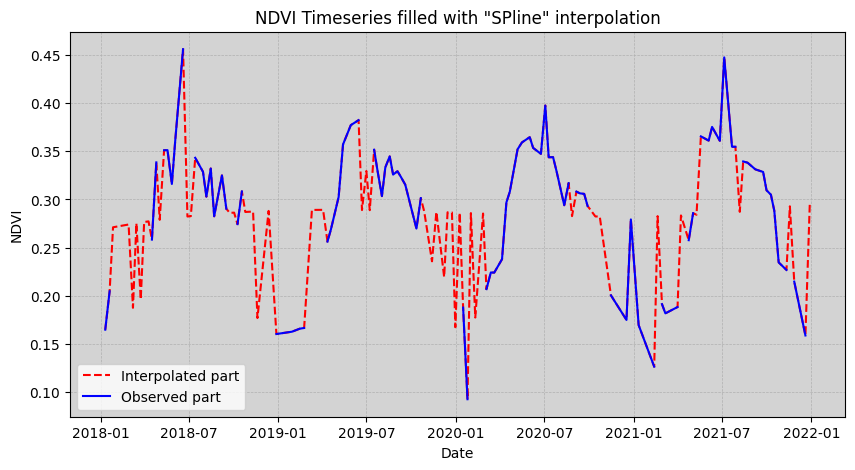

In [139]:
#let's plot the real and interpolated NDVI together 
#plot the new data
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.NDVI_interp, color='red', linestyle='--',linewidth=1.5, label='Interpolated part')
ax.plot(df.NDVI, color='blue', alpha=1, linewidth=1.5, label='Observed part')
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')
ax.set_title('NDVI Timeseries filled with "SPline" interpolation')
ax.legend()
ax.set_facecolor('lightgrey')
ax.grid(True, which='both', linewidth=0.5, linestyle='--')
fig.savefig(result_path/'spline.jpg', dpi=300)

Seems like the interpolated values are fluctuating too abruptly which is unusual for NDVI. Let's try some other interpolation method. However, some observed values also seems to cshow unusual sudden spike

In [141]:
#let's try linear interpolation
df['NDVI_linear'] = df['NDVI'].interpolate(method='linear')

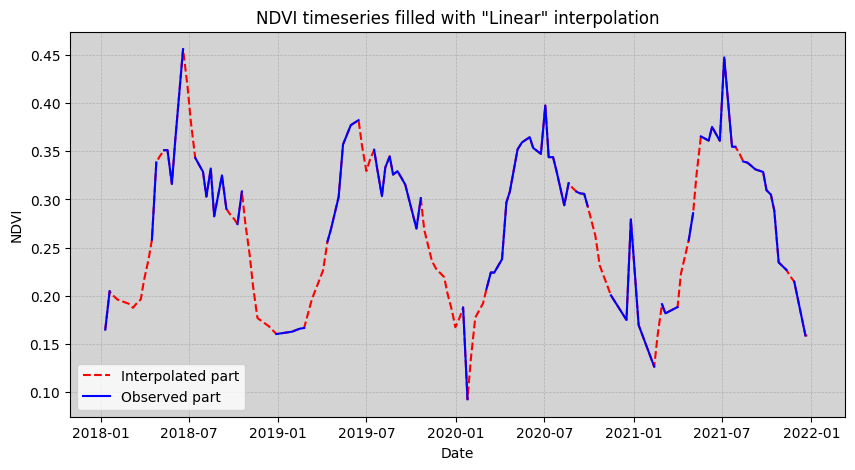

In [142]:
#plot 
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df.NDVI_linear, color='red', linestyle='--',  label='Interpolated part', linewidth=1.5 )
ax.plot(df.NDVI, color='blue', linewidth=1.5, label='Observed part')
ax.set_xlabel('Date')
ax.set_ylabel('NDVI')
ax.set_title('NDVI timeseries filled with "Linear" interpolation')
ax.legend()
ax.set_facecolor('lightgrey')
ax.grid(True, which='both', linewidth=0.5, linestyle='--')
fig.savefig(result_path/'ndvi_linear.jpg', dpi=300)

#### Looking at the seasonality

In [143]:
#coun the day of the year
df['doy'] = df.index.dayofyear
df

,NDVI,NDVI_interp,NDVI_linear,doy
date,,,,
2018-01-10,0.164864,0.164864,0.164864,10
2018-01-19,0.204688,0.204688,0.204688,19
2018-01-26,NaN,0.271115,0.200403,26
2018-02-04,NaN,0.271954,0.196118,35
2018-02-27,NaN,0.273988,0.191833,58
...,...,...,...,...
2021-11-11,0.226829,0.226829,0.226829,315
2021-11-18,NaN,0.292861,0.220774,322
2021-11-27,0.214719,0.214719,0.214719,331


In [144]:
#group it by day of the year and find mean of each day
df2 = df.groupby(by='doy').aggregate({'NDVI_linear':'mean'})
df2

,NDVI_linear
doy,
9,0.177582
10,0.164864
11,0.169582
16,0.187781
19,0.204688
...,...
358,0.184735
361,0.279258
362,0.160328


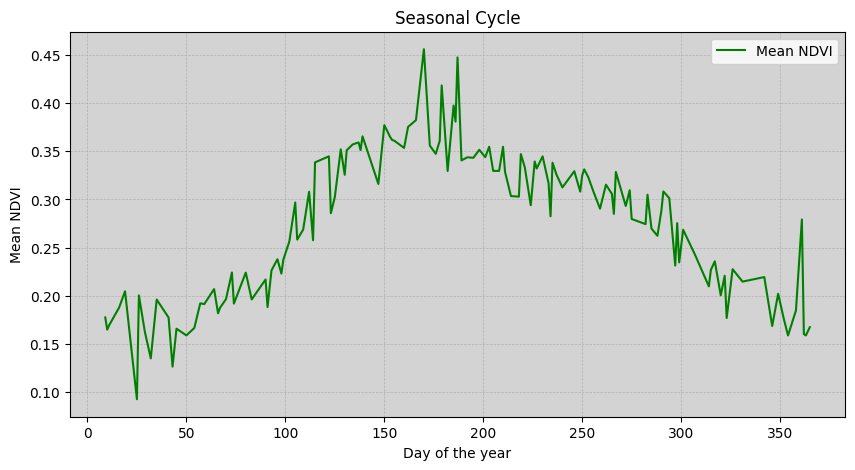

In [145]:
#visualize
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df2.NDVI_linear, color='green', linewidth = 1.5, label='Mean NDVI')
ax.set_xlabel('Day of the year')
ax.set_ylabel('Mean NDVI')
ax.set_title('Seasonal Cycle')
ax.set_facecolor('lightgrey')
ax.grid(True, which='both', linewidth=0.5, linestyle='--')
ax.legend()
fig.savefig(result_path/'seasonal_cycle.jpg', dpi=300)